# Implementing Sentiment Analysis

## 1. Installing packages

In [1]:
#Install/Upgrade dependencies
!pip install --upgrade awscli --user
!pip install --upgrade pip
!pip install --upgrade boto3
!pip install --upgrade botocore
!pip install --upgrade scikit-learn
!pip install --upgrade sagemaker
!pip install --upgrade nltk
!pip install --upgrade seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 142.5 MB/s eta 0:00:00
  Attempting uninstall: boto3
    Found existing installation: boto3 1.35.76
    Uninstalling boto3-1.35.76:
      Successfully uninstalled boto3-1.35.76
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 19.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.237.0
    Uninstalling sagemaker-2.237.0:
      Successfully uninstalled sagemaker-2.237.0


In [2]:
import boto3
import os, io, struct
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


True

In [3]:

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()
    
def print_metrics(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 



## 2. Reading the dataset

In [4]:
df = pd.read_csv('../data/imdb.csv', header=0)

## 3. Performing exploratory data analysi

In [5]:
def show_eight_rows(df):
    # Implement this function
    return df.head(8)    

In [6]:
print(show_eight_rows(df))

                                                text  label
0  What I hoped for (or even expected) was the we...      0
1  Garden State must rate amongst the most contri...      0
2  There is a lot wrong with this film. I will no...      1
3  To qualify my use of "realistic" in the summar...      1
4  Dirty War is absolutely one of the best politi...      1
5  Many other viewers are saying that this is not...      1
6  I understand that Roger Corman loves to do thi...      0
7  I love this show. I watched every episode last...      0


In [7]:
def show_data_shape(df):
    # Implement this function
    ### BEGIN_SOLUTION
    return df.shape
    ### END_SOLUTION

In [8]:
print(show_data_shape(df))

(50000, 2)


In [9]:
def show_data_instances(df):
    # Implement this function
    ### BEGIN_SOLUTION
    return df['label'].value_counts()
    ### END_SOLUTION

In [10]:
print(show_data_instances(df))

0    25000
1    25000
Name: label, dtype: int64


In [11]:
def show_missing_values(df):
    # Implement this function
    ### BEGIN_SOLUTION
    return df.isna().sum()
    ### END_SOLUTION
    

In [12]:
print(show_missing_values(df))

text     0
label    0
dtype: int64


## 4. Running the first pass: Minimal processing

In [13]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [14]:
from sklearn.model_selection import train_test_split
# uncomment the following lines and implement your solution
def split_data(df):
    # train, test_and_validate = train_test_split(....)
    # test, validate = train_test_split(....)
    ### BEGIN_SOLUTION
    train, test_and_validate = train_test_split(df,
                                            test_size=0.2,
                                            shuffle=True,
                                            random_state=324
                                            )
    test, validate = train_test_split(test_and_validate,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=324)
    ### END_SOLUTION
    return train, validate, test

In [15]:
train, validate, test = split_data(df)
print(train.shape)
print(test.shape)
print(validate.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [16]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

text_features = ['text']
model_target = 'label'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])

print('Datasets shapes before processing: ', train.shape, validate.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)
print('Datasets shapes after processing: ', train_matrix.shape, validate_matrix.shape, test_matrix.shape)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)
Datasets shapes after processing:  (40000, 500) (5000, 500) (5000, 500)
CPU times: user 7.51 s, sys: 99.9 ms, total: 7.61 s
Wall time: 7.89 s


In [17]:
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, X_train, y_train, is_test=False):
    csv_buffer = io.StringIO()
    features = [t.toarray().astype('float32').flatten().tolist() for t in X_train]
    if is_test:
        temp_list = features
    else:
        temp_list = np.insert(features, 0, y_train['label'], axis=1)
    np.savetxt(csv_buffer, temp_list, delimiter=',' )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [18]:
bucket = 'c144486a3735939l8857368t1w761809512073-labbucket-vh3oim8g7sdj'

In [19]:
prefix='lab41'
train_file='train-pass1.csv'
validate_file='validate-pass1.csv'
test_file='test-pass1.csv'

In [20]:
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)

In [21]:
import sagemaker
from sagemaker.image_uris import retrieve
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')
s3_output_location=f's3://{bucket}/{prefix}/output/'

hyperparams={"num_round":"42",
             "eval_metric": "error",
             "objective": "binary:logistic",
             "silent" : 1}

# xgb_model=sagemaker.estimator.Estimator(container,
#                                         role=<INSERT_ROLE_HERE>,
#                                         instance_count=<INSERT_COUNT_HERE>,
#                                         instance_type=<INSERT_INSTANCE_TYPE_HERE>,
#                                         output_path=s3_output_location,
#                                         hyperparameters=hyperparams,
#                                         sagemaker_session=sagemaker.Session())
### BEGIN_SOLUTION
xgb_model=sagemaker.estimator.Estimator(container,
                                        role=sagemaker.get_execution_role(),
                                        instance_count=1,
                                        instance_type='ml.m5.2xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())
### END_SOLUTION

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/02/25 09:48:08] INFO     Found credentials from IAM Role:                                   ]8;id=632717;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=233130;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[01/02/25 09:48:10] INFO     Defaulting to only available Python version: py3                     ]8;id=433408;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=936189;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=836875;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=191375;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#532\532]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=824130;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=629514;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=306149;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=444882;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=543598;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=497665;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [22]:
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}',
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [23]:
%%time

xgb_model.fit(inputs=data_channels, logs=False, job_name='xgb-pass1-'+datetime.now().strftime("%m-%d-%Y-%H-%M-%S"))

[01/02/25 09:48:11] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=561963;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=131307;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: xgb-pass1-01-02-2025-09-48-11         ]8;id=481554;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=598462;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\


2025-01-02 09:48:13 Starting - Starting the training job..
2025-01-02 09:48:27 Starting - Preparing the instances for training.....
2025-01-02 09:48:58 Downloading - Downloading input data.....
2025-01-02 09:49:28 Downloading - Downloading the training image.....
2025-01-02 09:49:59 Training - Training image download completed. Training in progress......
2025-01-02 09:50:30 Uploading - Uploading generated training model
2025-01-02 09:50:37 Completed - Training job completed
CPU times: user 156 ms, sys: 13.9 ms, total: 170 ms
Wall time: 2min 26s


In [24]:
sagemaker.analytics.TrainingJobAnalytics(xgb_model._current_job_name, 
                                         metric_names = ['train:error','validation:error']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,train:error,0.20855
1,0.0,validation:error,0.23550


In [25]:
%%time

upload_s3_csv('batch-in.csv', 'batch-in', test_matrix, test, True)
batch_X_file='batch-in.csv'
batch_output = f's3://{bucket}/{prefix}/batch-out/'
batch_input = f's3://{bucket}/{prefix}/batch-in/{batch_X_file}'

xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line',
                         job_name='xgboost-pass1')
xgb_transformer.wait(logs=False)

[01/02/25 09:50:40] INFO     Creating model with name: sagemaker-xgboost-2025-01-02-09-50-40-432    ]8;id=554320;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=180336;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating transform job with name: xgboost-pass1                        ]8;id=817836;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=505535;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\

...............................[2025-01-02:09:55:51:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:09:55:51:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:09:55:51:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2025-01-02 09:55:51 +0000] [27] [INFO] Starting guni

In [26]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/batch-out/batch-in.csv.out')
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)


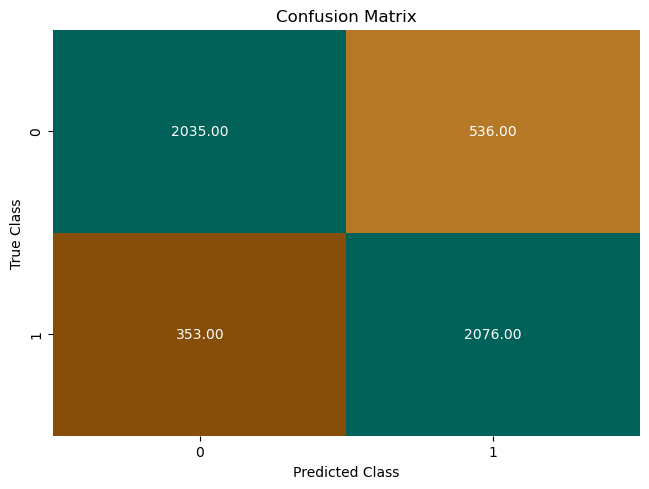

In [27]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [28]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 85.4672704816797%
Specificity or TNR: 79.15208090237262%
Precision: 79.47932618683001%
Negative Predictive Value: 85.2177554438861%
False Positive Rate: 20.847919097627383%
False Negative Rate: 14.532729518320298%
False Discovery Rate: 20.520673813169985%
Accuracy: 82.22%


## 5. Second pass: Normalizing the text

In [29]:
# Get a list of stopwords from the NLTK library
stop = stopwords.words('english')

def remove_stopwords(stopwords):
    # Implement this function
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t']
    ### BEGIN_SOLUTION
    excluding = ['against', 'not', 'don', 'don\'t','ain', 'are', 'aren\'t', 'could', 'couldn\'t',
             'did', 'didn\'t', 'does', 'doesn\'t', 'had', 'hadn\'t', 'has', 'hasn\'t', 
             'have', 'haven\'t', 'is', 'isn\'t', 'might', 'mightn\'t', 'must', 'mustn\'t',
             'need', 'needn\'t','should', 'shouldn\'t', 'was', 'wasn\'t', 'were', 
             'weren\'t', 'won\'t', 'would', 'wouldn\'t']
    ### END_SOLUTION
    return [word for word in stop if word not in excluding]

# New stopword list
stopwords = remove_stopwords(stop)


In [30]:
snow = SnowballStemmer('english')
def clean(sent):
    # Implement this function
    sent = sent.lower()
    sent = re.sub('\s+', ' ', sent)
    ### BEGIN_SOLUTION
    sent = sent.strip()
    sent = re.compile('<.*?>').sub('',sent)
    ### END_SOLUTION
    filtered_sentence = []
    
    for w in word_tokenize(sent):
        # You are applying custom filtering here. Feel free to try different things.
        # Check if it is not numeric, its length > 2, and it is not in stopwords
        if(not w.isnumeric()) and (len(w)>2) and (w not in stopwords):  
            # Stem and add to filtered list
            filtered_sentence.append(snow.stem(w))
    final_string = " ".join(filtered_sentence) #final string of cleaned words
    return final_string

In [31]:
# Uncomment the next line and implement the function call to split_data
#train, validate, test = 

### BEGIN_SOLUTION
train, validate, test = split_data(df)
### END_SOLUTION

print(train.shape)
print(test.shape)
print(validate.shape)

(40000, 2)
(5000, 2)
(5000, 2)


In [32]:
%%time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

text_features = ['text']
model_target = 'label'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(preprocessor=clean, max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])

print('Datasets shapes before processing: ', train.shape, validate.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)
print('Datasets shapes after processing: ', train_matrix.shape, validate_matrix.shape, test_matrix.shape)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/magics/execution │
│ .py:1350 in time                                                                                 │
│                                                                                                  │
│   1347 │   │   else:                                                                             │
│   1348 │   │   │   st = clock2()                                                                 │
│   1349 │   │   │   try:                                                                          │
│ ❱ 1350 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1351 │   │   │   │   out=None                                                                  │
│   1352 │   │   │   │   # multi-line %%time case                                                  │
│   1353 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:17                                                                                   │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_set_output.py: │
│ 319 in wrapped                                                                                   │
│                                                                                                  │
│   316 │                                                                                          │
│   317 │   @wraps(f)                                                                              │
│   318 │   def wrapped(self, X, *args, **kwargs):                                                 │
│ ❱ 319 │   │   data_to_wrap = f(self, X, *args, **kwargs)                                         │
│   320 │   │   if isinstance(data_to_wrap, tuple):                                                │
│   321 │   │   │   # only wrap the first output for cross decomposition                           │
│   322 │   │   │   return_tuple = (                                                               │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1389 in       │
│ wrapper                                                                                          │
│                                                                                                  │
│   1386 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1387 │   │   │   │   )                                                                         │
│   1388 │   │   │   ):                                                                            │
│ ❱ 1389 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1390 │   │                                                                                     │
│   1391 │   │   return wrapper                                                                    │
│   1392                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/compose/_column_trans │
│ former.py:1000 in fit_transform                                                                  │
│                                                                                                  │
│    997 │   │   else:                                                                             │
│    998 │   │   │   routed_params = self._get_empty_routing(

In [33]:
prefix='lab41'
train_file='train_pass2.csv'
validate_file='validate_pass2.csv'
test_file='test_pass2.csv'

In [34]:
### BEGIN_SOLUTION
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)
### END_SOLUTION

In [35]:
%%time

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

hyperparams={"num_round":"42",
             "eval_metric": "error",
             "objective": "binary:logistic",
             "silent" : 1}

### BEGIN_SOLUTION
xgb_model=sagemaker.estimator.Estimator(container,
                                        sagemaker.get_execution_role(),
                                        instance_count=1,
                                        instance_type='ml.m5.2xlarge',
                                        output_path=s3_output_location,
                                        hyperparameters = hyperparams,
                                        sagemaker_session=sagemaker.Session())

train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}',
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

### END_SOLUTION

xgb_model.fit(inputs=data_channels, logs=False, job_name='xgb-pass2-'+datetime.now().strftime("%m-%d-%Y-%H-%M-%S"))

[01/02/25 09:57:03] INFO     Defaulting to only available Python version: py3                     ]8;id=983974;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=706069;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=14273;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=494417;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#532\532]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=87457;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=18108;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: xgb-pass2-01-02-2025-09-57-03         ]8;id=730670;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=580761;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\


2025-01-02 09:57:04 Starting - Starting the training job.
2025-01-02 09:57:18 Starting - Preparing the instances for training......
2025-01-02 09:57:49 Downloading - Downloading input data...
2025-01-02 09:58:09 Downloading - Downloading the training image.....
2025-01-02 09:58:40 Training - Training image download completed. Training in progress.......
2025-01-02 09:59:15 Uploading - Uploading generated training model
2025-01-02 09:59:23 Completed - Training job completed
CPU times: user 246 ms, sys: 12.7 ms, total: 258 ms
Wall time: 2min 21s


In [36]:
sagemaker.analytics.TrainingJobAnalytics(xgb_model._current_job_name, 
                                         metric_names = ['train:error','validation:error']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,train:error,0.1985
1,0.0,validation:error,0.2265


In [37]:
%%time

### BEGIN_SOLUTION
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
### END_SOLUTION

xgb_transformer.wait(logs=False)

[01/02/25 09:59:25] INFO     Creating model with name: sagemaker-xgboost-2025-01-02-09-59-25-258    ]8;id=685524;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=400945;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating transform job with name:                                      ]8;id=955792;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=635107;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             sagemaker-xgboost-2025-01-02-09-59-25-844                                             

.............................[2025-01-02:10:04:13:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:10:04:13:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:10:04:13:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2025-01-02 10:04:14 +0000] [28] [INFO] Starting gunico

In [38]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)


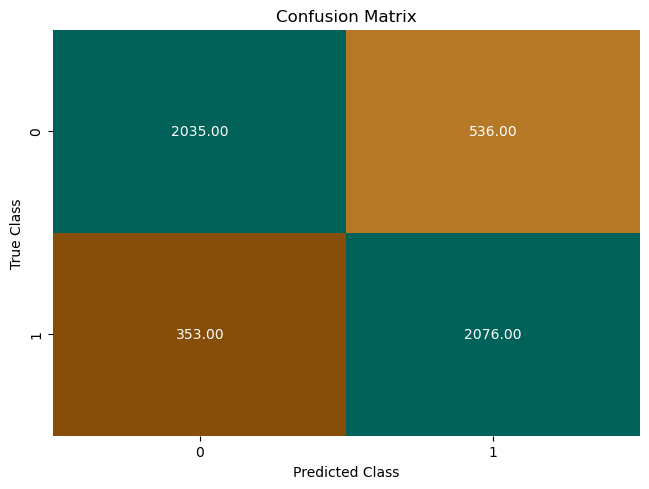

In [39]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [40]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 85.4672704816797%
Specificity or TNR: 79.15208090237262%
Precision: 79.47932618683001%
Negative Predictive Value: 85.2177554438861%
False Positive Rate: 20.847919097627383%
False Negative Rate: 14.532729518320298%
False Discovery Rate: 20.520673813169985%
Accuracy: 82.22%


## 6. Tuning hyperparameters

In [41]:
# xgb = sagemaker.estimator.Estimator(....)
### BEGIN_SOLUTION
xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m5.2xlarge', 
                                    output_path=f's3://{bucket}/{prefix}/output',
                                    sagemaker_session=sagemaker.Session())
### END_SOLUTION

In [42]:
xgb.set_hyperparameters(eval_metric='error',
                        objective='binary:logistic',
                        num_round=42,
                        silent=1)

In [43]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'alpha': ContinuousParameter(0,1000)}

### BEGIN_SOLUTION
hyperparameter_ranges = {'alpha': ContinuousParameter(0, 1000),
                         'min_child_weight': ContinuousParameter(0, 120),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.5),  
                         'num_round': IntegerParameter(1,4000)
                         }
### END_SOLUTION

In [44]:
objective_metric_name = '<INSERT_VALUE_HERE>'
objective_type = '<INSERT_VALUE_HERE>'

### BEGIN_SOLUTION
objective_metric_name = 'validation:error'
objective_type = 'Minimize'
### END_SOLUTION

In [45]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto',
                           )

In [46]:
%%time
tuner.fit(inputs=data_channels, include_cls_metadata=False, wait=False)

[01/02/25 10:04:54] WARNING  No finished training job found associated with this estimator.       ]8;id=430886;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=381349;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=740912;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=402853;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=501329;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=874545;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             sagemaker-xgboost-250102-1004                                                         

CPU times: user 24.1 ms, sys: 320 μs, total: 24.4 ms
Wall time: 462 ms


If you want to try Section 7 while you wait, don't run the next cell and go to Section 7.

In [47]:
tuner.wait()

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [48]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,0.000000,0.214144,71.105099,923.0,0.727433,sagemaker-xgboost-250102-1004-009-e756b7d6,Completed,0.1586,2025-01-02 10:33:27+00:00,2025-01-02 10:36:41+00:00,194.0
3,0.000000,0.489903,0.000000,4000.0,0.717790,sagemaker-xgboost-250102-1004-007-0b883ccd,Completed,0.1588,2025-01-02 10:17:47+00:00,2025-01-02 10:30:19+00:00,752.0
0,0.181592,0.284988,27.005314,2523.0,0.572244,sagemaker-xgboost-250102-1004-010-206d8388,Completed,0.1664,2025-01-02 10:37:25+00:00,2025-01-02 10:45:36+00:00,491.0
4,125.446664,0.122632,13.213603,2657.0,0.569374,sagemaker-xgboost-250102-1004-006-2e1649c2,Completed,0.1740,2025-01-02 10:12:56+00:00,2025-01-02 10:16:46+00:00,230.0
9,310.254555,0.227278,83.255900,229.0,0.633138,sagemaker-xgboost-250102-1004-001-a009e4ea,Completed,0.2118,2025-01-02 10:05:39+00:00,2025-01-02 10:07:29+00:00,110.0
6,502.314199,0.160154,33.683993,579.0,0.848169,sagemaker-xgboost-250102-1004-004-99df88fc,Completed,0.2332,2025-01-02 10:10:26+00:00,2025-01-02 10:11:30+00:00,64.0
5,429.188155,0.175903,92.855993,165.0,0.620714,sagemaker-xgboost-250102-1004-005-6d3558c2,Completed,0.2334,2025-01-02 10:11:46+00:00,2025-01-02 10:12:36+00:00,50.0
7,552.235695,0.206546,50.948400,1125.0,0.738213,sagemaker-xgboost-250102-1004-003-c8af6b00,Completed,0.2412,2025-01-02 10:08:41+00:00,2025-01-02 10:10:10+00:00,89.0
8,968.440957,0.129467,108.946347,4.0,0.506247,sagemaker-xgboost-250102-1004-002-e3aa395d,Completed,0.2924,2025-01-02 10:07:53+00:00,2025-01-02 10:08:32+00:00,39.0
2,0.000000,0.223194,0.000000,1.0,0.875013,sagemaker-xgboost-250102-1004-008-3f2d910a,Completed,0.2976,2025-01-02 10:32:27+00:00,2025-01-02 10:33:11+00:00,44.0


In [49]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [50]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2025-01-02 10:37:24 Starting - Found matching resource for reuse
2025-01-02 10:37:24 Downloading - Downloading the training image
2025-01-02 10:37:24 Training - Training image download completed. Training in progress.
2025-01-02 10:37:24 Uploading - Uploading generated training model
2025-01-02 10:37:24 Completed - Resource reused by training job: sagemaker-xgboost-250102-1004-010-206d8388


In [51]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

text_features = ['text']
model_target = 'label'

text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(preprocessor=clean, max_features=500))
])

data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])

print('Datasets shapes before processing: ', train.shape, validate.shape, test.shape)
train_matrix = data_preprocessor.fit_transform(train)
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)
print('Datasets shapes after processing: ', train_matrix.shape, validate_matrix.shape, test_matrix.shape)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/magics/execution │
│ .py:1350 in time                                                                                 │
│                                                                                                  │
│   1347 │   │   else:                                                                             │
│   1348 │   │   │   st = clock2()                                                                 │
│   1349 │   │   │   try:                                                                          │
│ ❱ 1350 │   │   │   │   exec(code, glob, local_ns)                                                │
│   1351 │   │   │   │   out=None                                                                  │
│   1352 │   │   │   │   # multi-line %%time case                                                  │
│   1353 │   │   │   │   if expr_val is not None:                                                  │
│ in <module>:17                                                                                   │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/utils/_set_output.py: │
│ 319 in wrapped                                                                                   │
│                                                                                                  │
│   316 │                                                                                          │
│   317 │   @wraps(f)                                                                              │
│   318 │   def wrapped(self, X, *args, **kwargs):                                                 │
│ ❱ 319 │   │   data_to_wrap = f(self, X, *args, **kwargs)                                         │
│   320 │   │   if isinstance(data_to_wrap, tuple):                                                │
│   321 │   │   │   # only wrap the first output for cross decomposition                           │
│   322 │   │   │   return_tuple = (                                                               │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1389 in       │
│ wrapper                                                                                          │
│                                                                                                  │
│   1386 │   │   │   │   │   prefer_skip_nested_validation or global_skip_validation               │
│   1387 │   │   │   │   )                                                                         │
│   1388 │   │   │   ):                                                                            │
│ ❱ 1389 │   │   │   │   return fit_method(estimator, *args, **kwargs)                             │
│   1390 │   │                                                                                     │
│   1391 │   │   return wrapper                                                                    │
│   1392                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/compose/_column_trans │
│ former.py:1000 in fit_transform                                                                  │
│                                                                                                  │
│    997 │   │   else:                                                                             │
│    998 │   │   │   routed_params = self._get_empty_routing(

Use the test data on a batch transformation by using the best algorithm from the hyperparameter tuning job.

In [52]:
%%time
upload_s3_csv('batch-in.csv', 'batch-in', test_matrix, test, True)

batch_output = f's3://{bucket}/{prefix}/batch-out/'
batch_input = f's3://{bucket}/{prefix}/batch-in/{batch_X_file}'

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

[01/02/25 10:46:22] INFO     Creating model with name: sagemaker-xgboost-2025-01-02-10-46-22-981    ]8;id=190669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=90750;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[01/02/25 10:46:23] INFO     Creating transform job with name:                                      ]8;id=35587;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=478247;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\
                             sagemaker-xgboost-2025-01-02-10-46-23-588                                             

..................................[2025-01-02:10:52:01:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:10:52:01:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:10:52:01:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:10:52:01:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-02:10:52:01:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout

Process the results to calculate the class.

In [53]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/batch-out/batch-in.csv.out')
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),sep=',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

target_predicted_binary = target_predicted['class'].apply(binary_convert)


Plot the confusion matrix and print the metrics.

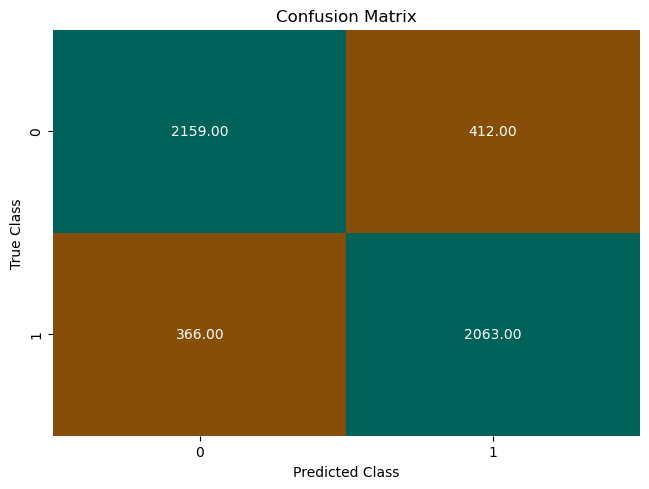

In [54]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [55]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 84.93207081103334%
Specificity or TNR: 83.9751069622715%
Precision: 83.35353535353536%
Negative Predictive Value: 85.5049504950495%
False Positive Rate: 16.02489303772851%
False Negative Rate: 15.067929188966653%
False Discovery Rate: 16.646464646464647%
Accuracy: 84.44%


In [56]:
import sagemaker
from sagemaker.image_uris import retrieve

container = retrieve('blazingtext',boto3.Session().region_name,"latest")

[01/02/25 10:52:52] INFO     Same images used for training and inference. Defaulting to image     ]8;id=900912;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=80106;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#391\391]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=442275;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=212032;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

In [57]:
import io
    
prefix='lab41'
train_file='blazing_train.txt'
validate_file='blazing_validate.txt'
test_file='blazing_test.txt'

In [58]:
train.head()

,text,label
29572,Caught this movie on the tube on a Sunday. I t...,0
42816,Seeing as Keifer Sutherland plays my favorite ...,1
15853,"Stan as a bullfighter, and a good one, is quit...",1
38282,Ok so I was bored and I watched it all the way...,0
36321,This can't be Mandy Schaffer's last film. Some...,0


In [59]:
blazing_text_buffer = io.StringIO()
train.to_string(buf=blazing_text_buffer, columns=['label','text'], header=False, index=False, formatters=
                         {'label': '__label__{}'.format})
s3r = boto3.resource('s3')
s3r.Bucket(bucket).Object(os.path.join(prefix, 'blazing', train_file)).put(Body=blazing_text_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '2CJDRCJ4ATP8SJVD',
  'HostId': 'lC7En1gu162bTe4BqcC2wljhOgD6o7MdbAzPxRxg8Cvx6Ato+2H30Av9kfFfDWVRGF5wxPm8//4W73wFMFTYROLHgbQi7uS4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lC7En1gu162bTe4BqcC2wljhOgD6o7MdbAzPxRxg8Cvx6Ato+2H30Av9kfFfDWVRGF5wxPm8//4W73wFMFTYROLHgbQi7uS4',
   'x-amz-request-id': '2CJDRCJ4ATP8SJVD',
   'date': 'Thu, 02 Jan 2025 10:52:56 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"d2cbe833d8eace19960f9eeb3939980a"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"d2cbe833d8eace19960f9eeb3939980a"',
 'ServerSideEncryption': 'AES256'}

In [60]:
blazing_text_buffer = io.StringIO()
validate.to_string(buf=blazing_text_buffer, columns=['label','text'], header=False, index=False, formatters=
                         {'label': '__label__{}'.format})
s3r.Bucket(bucket).Object(os.path.join(prefix, 'blazing', validate_file)).put(Body=blazing_text_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'RTDZ2KEXS2AEW9W7',
  'HostId': 'Zzcz3c+bkHi3pgt1UWDe34SS57HXCeWE6TSKQkttZ0H6JYp4z+noil+0iYZtUsrJxcEsy9USBloB2m49H8QmkFrwTSCEiGo5',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Zzcz3c+bkHi3pgt1UWDe34SS57HXCeWE6TSKQkttZ0H6JYp4z+noil+0iYZtUsrJxcEsy9USBloB2m49H8QmkFrwTSCEiGo5',
   'x-amz-request-id': 'RTDZ2KEXS2AEW9W7',
   'date': 'Thu, 02 Jan 2025 10:53:00 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"454e6e28ce395eb3c0ec56e8a5755f20"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"454e6e28ce395eb3c0ec56e8a5755f20"',
 'ServerSideEncryption': 'AES256'}

In [61]:
# bt_model = sagemaker.estimator.Estimator(container,
#                                         sagemaker.get_execution_role(), 
#                                         instance_count=, 
#                                         instance_type=,
#                                         volume_size = 30,
#                                         max_run = 360000,
#                                         input_mode= 'File',
#                                         output_path=,
#                                         sagemaker_session=

### BEGIN_SOLUTION
bt_model = sagemaker.estimator.Estimator(container,
                                         sagemaker.get_execution_role(), 
                                         instance_count=1, 
                                         instance_type='ml.c4.4xlarge',
                                         volume_size = 30,
                                         max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

### END_SOLUTION

In [62]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=10,
                            min_count=2,
                            learning_rate=0.05,
                            vector_dim=10,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5,
                            word_ngrams=2)

In [63]:
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/blazing/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/blazing/{validate_file}',
    content_type='text/csv')

data_channels_3 = {'train': train_channel, 'validation': validate_channel}

In [64]:
%%time

### BEGIN_SOLUTION
bt_model.fit(inputs=data_channels_3, logs=False)
### END_SOLUTION

[01/02/25 10:53:00] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=365859;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=633086;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name: blazingtext-2025-01-02-10-53-00-261   ]8;id=577779;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=844389;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\


2025-01-02 10:53:01 Starting - Starting the training job.
2025-01-02 10:53:15 Starting - Preparing the instances for training.....
2025-01-02 10:53:42 Downloading - Downloading input data...
2025-01-02 10:54:03 Downloading - Downloading the training image
2025-01-02 10:54:08 Training - Training image download completed. Training in progress.......
2025-01-02 10:54:43 Uploading - Uploading generated training model
2025-01-02 10:54:51 Completed - Training job completed
CPU times: user 106 ms, sys: 30 ms, total: 136 ms
Wall time: 1min 51s


In [65]:
sagemaker.analytics.TrainingJobAnalytics(bt_model._current_job_name, 
                                         metric_names = ['train:accuracy','validation:accuracy']
                                        ).dataframe()

,timestamp,metric_name,value
0,0.0,train:accuracy,0.9137
1,0.0,validation:accuracy,0.8718


In [66]:
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

In [67]:
bt_test = test.copy()
bt_test.head()

,text,label
16591,"This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film.",1
21931,"I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all, I have seen worse but this sure isn't one I'd recommend or want to remember.",0
22143,"There have been several comments already on the site focusing on the ""prestige"" feel of the film - and there is a lot of heavy-weight talent on show: from Fiennes and Scott-Thomas to the magnificently rendered design and scoring, to the masterly direction. No wonder that Andrew Lloyd Webber's acceptance speech for ""Evita"" at that year's Oscars began ""Well, thank God that ""The English Patient"" had no songs in it."" Writing of Oscar winners takes me to Juliette Binoche, who, in a stellar cast, gives a beautiful performance. It is heartening to see that the dynamics which seem to influence the award for Best Actor (often going to showy pyrotechnic display) aren't at work in the female categories. Just as Emma Thompson's hugely well-deserved Oscar for her portrayal of Margaret Schlegel in ""Howard's End"" proved that one of the hardest things that an actor can do is make the portrayal of ""goodness"" involving, so Binoche's win proved that it could be that - and seriously sexy. Her performance in this terrific film is a thing of beauty.",1
1133,"My wife and I struggle to find movies like this that are clean and yet enjoyable for adults. If you can't find a cinema that is playing it, call your cinema and request it. Bravo, Five Sisters Productions for courage, tenacity and creative endeavor!",1
10413,"Basil Rathbone and Nigel Bruce return as Sherlock Holmes and Dr. Watson in this superior tale of Holmes battling the 3rd Reich and the mastermind genius of Professor Moriarty. The film opens up in Switzerland as Holmes is in disguise as an ""old bookseller."" He must bring Dr. Tobel and the Tobel Bomb Site to England before the Germans can kidnap Tobel. Holmes succeeds and the Germans recuit the evil Professor. Moriarty manages to outwit Scotland yard and LeStrad ""Dennis Hoey"" by kidnapping Tobel. The only clue left by Tobel is a list of ""dancing men."" Who will break the hidden code of dancing men, Holmes or Moriarty first? Can Holmes prevent the bomb site from falling into the German hands thereby saving England from the precision bombing techniques developed by Tobel's bomb site? Watch and enjoy.",1


In [68]:
# bt_test['text'].str.strip()
bt_test.replace(r'\\n','', regex=True, inplace = True)
bt_test.rename(columns={'text':'source'}, inplace=True)
bt_test.drop(columns='label', inplace=True)

In [69]:
print(bt_test.head().to_json(orient="records", lines=True))

{"source":"This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film."}
{"source":"I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all,

In [70]:
bt_file = 'bt_input.json'
blazing_text_buffer = io.StringIO()
bt_test.to_json(path_or_buf=blazing_text_buffer, orient="records", lines=True)

In [71]:
s3r.Bucket(bucket).Object(os.path.join(prefix, 'blazing', bt_file)).put(Body=blazing_text_buffer.getvalue())


{'ResponseMetadata': {'RequestId': 'W5KCMN5M7EBB9RJB',
  'HostId': '6KHr+uRAPqMRcy8wDIiTVK01FZ7esHDjWrmt3XOvHDiDjH6iwYz5bKXcBxhJUy8QM79JAGzqxBlfi+E8XVeTRJqa3eRLd7E0cgwZDUBoGJ4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '6KHr+uRAPqMRcy8wDIiTVK01FZ7esHDjWrmt3XOvHDiDjH6iwYz5bKXcBxhJUy8QM79JAGzqxBlfi+E8XVeTRJqa3eRLd7E0cgwZDUBoGJ4=',
   'x-amz-request-id': 'W5KCMN5M7EBB9RJB',
   'date': 'Thu, 02 Jan 2025 10:54:52 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"38b2ee8737428c6d3f47a6a861556d6f"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"38b2ee8737428c6d3f47a6a861556d6f"',
 'ServerSideEncryption': 'AES256'}

In [72]:
batch_output = f's3://{bucket}/{prefix}/blazing/'
batch_input = f's3://{bucket}/{prefix}/blazing/{bt_file}'

In [73]:
%%time
bt_transformer = bt_model.transformer(instance_count=1,
                                       instance_type='ml.m5.2xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

bt_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='application/jsonlines',
                         split_type='Line')

bt_transformer.wait(logs=True)

[01/02/25 10:54:52] INFO     Creating model with name: blazingtext-2025-01-02-10-54-52-128          ]8;id=682005;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=319233;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating transform job with name: blazingtext-2025-01-02-10-54-52-725  ]8;id=342678;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=547136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3951\3951]8;;\

........................
.Arguments: serve
[01/02/2025 10:58:57 INFO 140055954982720] Finding and loading model
[01/02/2025 10:58:57 INFO 140055954982720] Trying to load model from /opt/ml/model/model.bin
[01/02/2025 10:58:57 INFO 140055954982720] Number of server workers: 8
[2025-01-02 10:58:57 +0000] [1] [INFO] Starting gunicorn 20.1.0
[2025-01-02 10:58:57 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2025-01-02 10:58:57 +0000] [1] [INFO] Using worker: sync
[2025-01-02 10:58:57 +0000] [37] [INFO] Booting worker with pid: 37
[2025-01-02 10:58:57 +0000] [38] [INFO] Booting worker with pid: 38
[2025-01-02 10:58:57 +0000] [39] [INFO] Booting worker with pid: 39
[2025-01-02 10:58:57 +0000] [40] [INFO] Booting worker with pid: 40
[2025-01-02 10:58:57 +0000] [41] [INFO] Booting worker with pid: 41
[2025-01-02 10:58:57 +0000] [42] [INFO] Booting worker with pid: 42
[2025-01-02 10:58:57 +0000] [43] [INFO] Booting worker with pid: 43
[2025-01-02 10:58:57 +0000] [44] [INFO] Booting w

Retrieve the results from Amazon S3.

In [74]:
obj = s3.get_object(Bucket=bucket, Key=f'{prefix}/blazing/bt_input.json.out')

In [75]:
target_predicted = pd.read_json(io.BytesIO(obj['Body'].read()),lines=True)

In [76]:
target_predicted.head()

,label,prob
0,[__label__1],[0.9998418092727661]
1,[__label__0],[0.8831659555435181]
2,[__label__1],[0.8606650829315181]
3,[__label__1],[0.9784248471260071]
4,[__label__1],[0.7711000442504881]


Reformat the results so that you can calculate the confusion matrix and the metrics.

In [77]:
def binary_convert(label):
    label = label[0].replace('__label__','')
    return int(label)

target_predicted_binary = target_predicted['label'].apply(binary_convert)

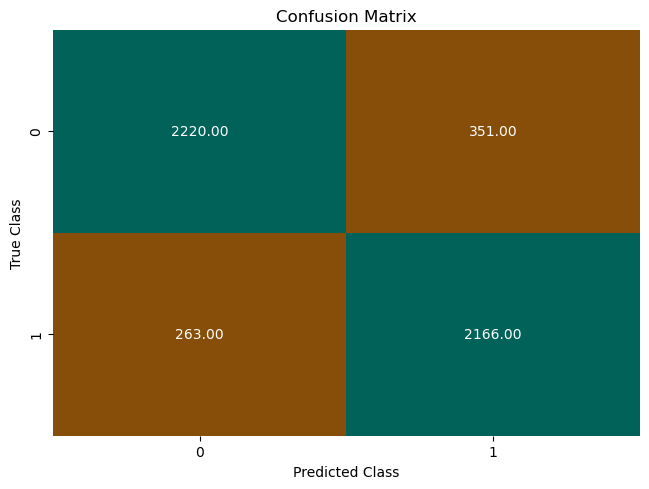

In [78]:
plot_confusion_matrix(test['label'], target_predicted_binary)

In [79]:
print_metrics(test['label'], target_predicted_binary)

Sensitivity or TPR: 89.17249897076987%
Specificity or TNR: 86.34772462077012%
Precision: 86.05482717520859%
Negative Predictive Value: 89.40797422472815%
False Positive Rate: 13.652275379229872%
False Negative Rate: 10.827501029230135%
False Discovery Rate: 13.945172824791419%
Accuracy: 87.72%


How did BlazingText perform compared to the previous models?

Review what the data looks like in the `test` dataframe.

## 8. Using Amazon Comprehend

In [80]:
test.head()

,text,label
16591,"This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film.",1
21931,"I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all, I have seen worse but this sure isn't one I'd recommend or want to remember.",0
22143,"There have been several comments already on the site focusing on the ""prestige"" feel of the film - and there is a lot of heavy-weight talent on show: from Fiennes and Scott-Thomas to the magnificently rendered design and scoring, to the masterly direction. No wonder that Andrew Lloyd Webber's acceptance speech for ""Evita"" at that year's Oscars began ""Well, thank God that ""The English Patient"" had no songs in it."" Writing of Oscar winners takes me to Juliette Binoche, who, in a stellar cast, gives a beautiful performance. It is heartening to see that the dynamics which seem to influence the award for Best Actor (often going to showy pyrotechnic display) aren't at work in the female categories. Just as Emma Thompson's hugely well-deserved Oscar for her portrayal of Margaret Schlegel in ""Howard's End"" proved that one of the hardest things that an actor can do is make the portrayal of ""goodness"" involving, so Binoche's win proved that it could be that - and seriously sexy. Her performance in this terrific film is a thing of beauty.",1
1133,"My wife and I struggle to find movies like this that are clean and yet enjoyable for adults. If you can't find a cinema that is playing it, call your cinema and request it. Bravo, Five Sisters Productions for courage, tenacity and creative endeavor!",1
10413,"Basil Rathbone and Nigel Bruce return as Sherlock Holmes and Dr. Watson in this superior tale of Holmes battling the 3rd Reich and the mastermind genius of Professor Moriarty. The film opens up in Switzerland as Holmes is in disguise as an ""old bookseller."" He must bring Dr. Tobel and the Tobel Bomb Site to England before the Germans can kidnap Tobel. Holmes succeeds and the Germans recuit the evil Professor. Moriarty manages to outwit Scotland yard and LeStrad ""Dennis Hoey"" by kidnapping Tobel. The only clue left by Tobel is a list of ""dancing men."" Who will break the hidden code of dancing men, Holmes or Moriarty first? Can Holmes prevent the bomb site from falling into the German hands thereby saving England from the precision bombing techniques developed by Tobel's bomb site? Watch and enjoy.",1


In [81]:
import boto3
import json

comprehend = boto3.client(service_name='comprehend')
for n in range(5):
    text = test.iloc[n]['text']
    response = comprehend.detect_sentiment(Text=text, LanguageCode='en')
    sentiment = response['Sentiment']
    print(f'{sentiment} - {text}')


POSITIVE - This is a charming movie starring everyone's favorite cartoon chipmunks. In this feature we follow the band of rodents on an unforgettable balloon race around the world. Although there are lows, including an orphan penguin, all in all it's a great family film.
MIXED - I really should have learned more about this movie before renting it. It was one of those movies where you keep watching it figuring it's got to get better. Then, when it ends, you feel stupid for having wasted precious time in your life that you can never get back. Ice-T did his bad guy thing and, well, that was the highlight of the evening. The pictures of the shuttle looks like it was done with a little toy inside of a box and the spacewalking scenes were funny because you could see the strings attached to the space suits. The script was lacking and the car chase scene with the guy bleeding and going unconscious was incredible because he drove better than I could have on one of my best days. All in all, I ha

In [82]:
# Upload test file minus label to S3
def upload_comprehend_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

comprehend_file = 'comprehend_input.csv'
upload_comprehend_s3_csv(comprehend_file, 'comprehend', test['text'].str.slice(0,5000))
test_url = f's3://{bucket}/{prefix}/comprehend/{comprehend_file}'
print(f'Uploaded input to {test_url}')

Uploaded input to s3://c144486a3735939l8857368t1w761809512073-labbucket-vh3oim8g7sdj/lab41/comprehend/comprehend_input.csv


In [83]:
input_data_config={
    'S3Uri': 'S3_INPUT_GOES_HERE',
    'InputFormat': 'INPUT_FORMAT_GOES_HERE'
},

output_data_config={
    'S3Uri': 'S3_OUTPUT_GOES_HERE'
},
data_access_role_arn = 'arn:aws:iam::761809512073:role/service-role/c144486a3735939l8857368t1w-ComprehendDataAccessRole-H9gK8KtksOGz'

### BEGIN_SOLUTION
input_data_config={
    'S3Uri': test_url,
    'InputFormat': 'ONE_DOC_PER_LINE'
}
output_data_config={
    'S3Uri': s3_output_location
}
data_access_role_arn = 'arn:aws:iam::761809512073:role/service-role/c144486a3735939l8857368t1w-ComprehendDataAccessRole-H9gK8KtksOGz'
### END_SOLUTION

In [84]:
response = comprehend.start_sentiment_detection_job(
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    DataAccessRoleArn=data_access_role_arn,
    JobName='movie_sentiment',
    LanguageCode='en'
)

print(response['JobStatus'])

SUBMITTED


In [85]:
%%time
import time
job_id = response['JobId']
while True:
    job_status=(comprehend.describe_sentiment_detection_job(JobId=job_id))
    if job_status['SentimentDetectionJobProperties']['JobStatus'] in ['COMPLETED','FAILED']:
        break            
    else:
        print('.', end='')
    time.sleep(15)
print((comprehend.describe_sentiment_detection_job(JobId=job_id))['SentimentDetectionJobProperties']['JobStatus'])

.................................COMPLETED
CPU times: user 497 ms, sys: 38.7 ms, total: 536 ms
Wall time: 8min 17s


In [86]:
output=(comprehend.describe_sentiment_detection_job(JobId=job_id))
print(output)

{'SentimentDetectionJobProperties': {'JobId': 'a04a5fa7d68d27a640a85e0b913ad67b', 'JobArn': 'arn:aws:comprehend:us-east-1:761809512073:sentiment-detection-job/a04a5fa7d68d27a640a85e0b913ad67b', 'JobName': 'movie_sentiment', 'JobStatus': 'COMPLETED', 'SubmitTime': datetime.datetime(2025, 1, 2, 10, 59, 26, 456000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2025, 1, 2, 11, 7, 33, 965000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://c144486a3735939l8857368t1w761809512073-labbucket-vh3oim8g7sdj/lab41/comprehend/comprehend_input.csv', 'InputFormat': 'ONE_DOC_PER_LINE'}, 'OutputDataConfig': {'S3Uri': 's3://c144486a3735939l8857368t1w761809512073-labbucket-vh3oim8g7sdj/lab41/output/761809512073-SENTIMENT-a04a5fa7d68d27a640a85e0b913ad67b/output/output.tar.gz'}, 'LanguageCode': 'en', 'DataAccessRoleArn': 'arn:aws:iam::761809512073:role/service-role/c144486a3735939l8857368t1w-ComprehendDataAccessRole-H9gK8KtksOGz'}, 'ResponseMetadata': {'RequestId': '84c3ca53-cf69-4d68-90a0-c4f83e788

In [87]:
comprehend_output_file = output['SentimentDetectionJobProperties']['OutputDataConfig']['S3Uri']
comprehend_bucket, comprehend_key = comprehend_output_file.replace("s3://", "").split("/", 1)

s3r = boto3.resource('s3')
s3r.meta.client.download_file(comprehend_bucket, comprehend_key, 'output.tar.gz')

# Extract the tar file
import tarfile
tf = tarfile.open('output.tar.gz')
tf.extractall()

In [88]:
import json
data = ''
with open ('output', "r") as myfile:
    data = myfile.readlines()

In [89]:
results = []
for line in data:
    json_data = json.loads(line)
    results.append([json_data['Line'],json_data['Sentiment']])

In [90]:
c = pd.DataFrame.from_records(results, index='index', columns=['index','sentiment'])
c.head()

,sentiment
index,
1,MIXED
2,POSITIVE
4,NEUTRAL
6,NEUTRAL
7,POSITIVE


In [91]:
class_mapper = {'NEGATIVE':0, 'POSITIVE':1, 'NEUTRAL':2, 'MIXED':3}
c['sentiment']=c['sentiment'].replace(class_mapper)
c = c.sort_index()
c.head()

,sentiment
index,
0,1
1,3
2,1
3,1
4,2


In [92]:
# Build list to compare for Amazon Comprehend
test_2 = test.reset_index()
test_3 = test_2.sort_index()
test_labels = test_3.iloc[:,2]

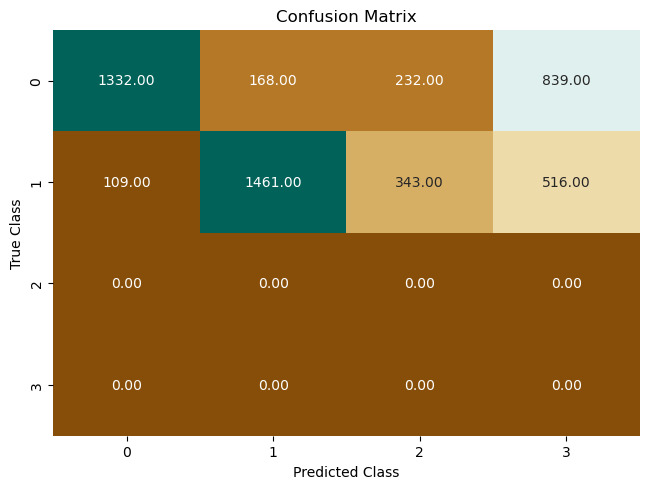

In [93]:
plot_confusion_matrix(test_labels, c['sentiment'])

In [94]:
cm = confusion_matrix(test_labels, c['sentiment'])

TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]
TP = cm[1,1]

Sensitivity  = float(TP)/(TP+FN)*100
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
# False negative rate
FNR = float(FN)/(TP+FN)*100
# False discovery rate
FDR = float(FP)/(TP+FP)*100
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100

print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%") 

Sensitivity or TPR: 93.05732484076434%
Specificity or TNR: 88.8%
Precision: 89.68692449355433%
Negative Predictive Value: 92.43580846634282%
False Positive Rate: 11.200000000000001%
False Negative Rate: 6.942675159235669%
False Discovery Rate: 10.313075506445673%
Accuracy: 90.9771986970684%
